# Predict2Win: Next Event Prediction in Football Matches Using Deep Learning Models

**Felix Hofer, Antreas Vasileiou, Julian Wuth**

## Table of Contents
1. Background
    
    1.1 GitHub Repository & Dependencies
2. Data Import & Preprocessing
    
    2.1 Download Data from GitHub
    
    2.2 Hyperparameters
    
    2.3 Data Preprocessing
    
    2.4 The Final (Preprocessed) Dataset
    
    2.5 Dataset and Dataloader Classes

3. Methods  

    3.1 Single Layer Model (Baseline)

    3.2 Transformer

    3.3 LSTM

    3.4 Training Function

    3.5 Model Training

4. Results

    4.1 Confusion Matrices

    4.2 Weighted Loss Idea (Transformer Implementation)

5. Discussion

6. Division of labour

7. References

## Disclaimer
Some of the ideas in this project were inspired by the work of Simpson et al. (2022), a project that also aimed in predicitng football events but with a slightly different end goal. No actual code was copy-pasted, only some of their ideas were adpated in this project in our own coding logic. Furthermore, AI (i.e., ChatGPT 5.1) was used to assist in writing this notebook. No actual code or information was copy-pasted. The AI was used mainly to help with implementing our ideas (e.g., looking up if certain functions exist) or to check if our understanding of different concepts or functions (e.g., Dataset, Dataloader, classes, etc.) is correct.

## 1. Background
The general idea was to build a deep neural network (DNN) for next-event prediction in time series data. In recent years, deep learning has become widely used for such tasks due to its ability to capture complex, non-linear relationships within data (Hall & Rasheed, 2025). Because of our personal interest in football, we aimed to build a DNN that predicts next events (shot, pass, etc.) in football matches, given a preceding sequence of events. More specifically, we compared the performance of a *transformer* and a *recurrent model with long short-term memory (LSTM)*. 

Initially, we thought that a recurrent model would best fit this kind of task since it can capitalize on the temporal aspect of time series events. However, inspired by the idea of next-word prediction with transformers, we also had the idea to treat individual events as words and use preceding events as the context to predict the event. 

To establish a fair baseline, apart from comparing with majority class prediction (always predicting the most frequent event in the dataset), we also trained a single-layer network (input-output). We hypothesize that the DNNs will outperform both the majority class and the single-layer network in predicting next events, since they are able to capture non-linear relationships most likely present in football matches.

While working on the project, we found that Simpson et al. (2022) have previously explored a similar idea with the same dataset. However, their implementation and end goal differ from those of the present project. Their results show that DNNs find structure in time series data and utilize their temporality. Data science and deep learning techniques, in particular, have become increasingly integrated into sports analytics. Using such deep learning techniques to extract information from football data is a valuable asset for professional teams looking to improve their analysis techniques.

### 1.1 GitHub Repository & Dependencies:
This project is uploaded to the following [GitHub repository](https://github.com/jvli4n/DLiP2025_football_analysis). The repository contains the final version of this jupyter notebook, the wyscout data used here, and a requirements text file that includes all dependencies for this project. 

Running the following cell will install all dependencies required to run this notebook.

In [9]:
!pip install -r https://raw.githubusercontent.com/jvli4n/DLiP2025_football_analysis/refs/heads/main/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 7.8 MB/s eta 0:00:00ta 0:00:01


Import necessary libraries.

In [10]:
# Standard Python Libraries
import os
import time
import copy
import json
import pickle
import requests
import warnings

# Other Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from zipfile import ZipFile

from tqdm.auto import tqdm
from IPython.display import clear_output
from pandas.api.types import is_categorical_dtype
from concurrent.futures import ThreadPoolExecutor, as_completed

from kloppy import wyscout
from kloppy.domain import Provider, Dimension, NormalizedPitchDimensions, Orientation

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler

from torchmetrics.classification import ConfusionMatrix

## 2. Data Import & Preprocessing

The data used in this project are openly provided by Wyscout (Pappalardo et al., 2019), a company aiming to create large-scale sports datasets. We also used the [Kloppy](https://kloppy.pysport.org/) library [(PySport)](https://pysport.org/), which allows for convinient extraction and transformation of Wyscout football match data.

The dataset includes 1941 matches from the Top 5 European leagues, the 2018 FIFA World Cup and the 2020 UEFA Euro Cup.

**Note: Before running the following cell, set `project_path` to the directory where you want to save the data. Otherwise, the project directory will be set to your current working directory!**

In [ ]:
project_path = os.getcwd() # specify path where data should be saved

Importing the Wyscout data using Kloppy takes approximately 14 minutes. The GitHub repository already includes a zip file containing the Wyscout data used in this project. **To save time, run the following cell (download_zip() function) and skip ahead to section 2.1 Download Data from GitHub**.

In [14]:
def download_zip(url, save_path):
  """
  Helper function to download and unzip files from a url.
  """

  # save location
  save_dir = Path(save_path)
  save_dir.mkdir(parents=True, exist_ok=True)

  # create the zip folder path
  zip_name = url.split("/")[-1]
  zip_stem = zip_name.rsplit(".", 1)[0]
  zip_path = save_dir / zip_name

  # create folder to unzip
  unzip_dir = save_dir / zip_stem
  os.makedirs(unzip_dir, exist_ok=True)

  print(save_dir, zip_name, zip_stem, zip_path, unzip_dir)

  response = requests.get(url) # send GET request
  response.raise_for_status()  # error if download failed

  # download zip file
  with open(zip_path, 'wb') as f:
   f.write(response.content)

  # unzip file
  with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

  print(f"Downloaded: {url.split('/')[-1]}")

Pappalardo et al. (2019) made part of their data publicly available on Figshare. The following cell downloads the match IDs used to extract the football match data with Kloppy.

In [ ]:
# match ids for referencing the matches after extracting with kloppy
matches_url = "https://figshare.com/ndownloader/files/14464622/matches.zip"
download_zip(matches_url, project_path)

The following helper function is required to distribute the workload across multiple CPU cores when loading the individual matches (i.e., for parallel processing). After the matches are loaded, they are also transformed with some functions from the Kloppy library. First, the pitch dimensions are normalized because some providers give different pitch dimensions. Next, a standard coordinate system is used for the same reason. Orientations are made static (no halftime switch), because the model might get fed a data window from overlapping periods. This way we do not have to specify periods and also save some memory.

In [ ]:
def load_match(match_id):
    """Helper function for loading a single match with kloppy."""
    try:
        dataset = wyscout.load_open_data(match_id=match_id, coordinates="wyscout")

        # Normalize data
        dataset = dataset.transform(to_pitch_dimensions=NormalizedPitchDimensions(pitch_length=105,
                                                        pitch_width=68,
                                                        x_dim = Dimension(0, 1),
                                                        y_dim = Dimension(0, 1)),
                                    to_coordinate_system = Provider.WYSCOUT,
                                    to_orientation = Orientation.STATIC_HOME_AWAY)
        dataset = dataset.to_df()
        return match_id, dataset

    except Exception as e:
        print(f"Failed match {match_id}: {e}")
        return match_id, None


In [ ]:
def load_kloppy(matches_path, save_path):
  """
  Helper function to load and normalize match data from wyscout using kloppy.
  Saves everything into a dictionary with match ids as keys and dataframes for each match as values.
  The dictionary is saved as a pickle file at save_path.
  """
  # The first part get's the matchIDs so we can use them later to load single matches
  matches_dir = Path(matches_path)
  match_ids = [] # buffer for match ids

  # collect json files containing matchid
  for comp in matches_dir.glob("*.json"): # find and loop through .json files
    with comp.open("r") as f:
      data = json.load(f) # load json

      for mtch in data:
        match_ids.append(mtch["wyId"]) #Append unique matchID

  data_dict = {}
  # Parallelize data import and transform
  with ThreadPoolExecutor(max_workers=None) as ex: # Default = all workers
    for match_id, df in tqdm(ex.map(load_match, match_ids), #tqdm creates the loading buffer
                             total=len(match_ids),
                             desc="Loading matches"):
      if df is None:
        continue
      data_dict[match_id] = df # Data fictionary with matchID as key and df as value

  print(f"Total matches loaded: {len(data_dict)}")

  # save dictionary as .pkl
  with open(save_path, "wb") as f:
    pickle.dump(data_dict, f)

  print(f"Dictionary saved at {save_path}")

In [ ]:
# load the data using the function
matches_path = os.path.join(project_path, "matches")
dict_path = os.path.join(project_path, "wyscout_data.pkl")
load_kloppy(matches_path, dict_path)

### 2.1 Download Data from GitHub

The cell below downloads a dictionary from our GitHub repository, that contains the match IDs as keys and the corresponding events in DataFrame form as values.

In [15]:
# data is provided in GitHub repo
github_link = 'https://github.com/jvli4n/DLiP2025_football_analysis/raw/refs/heads/main/wyscout_data.zip'

# download zip from GitHub
download_zip(github_link, project_path)

# extract the data_dict from the .zip file
dict_path = os.path.join(project_path, "wyscout_data.zip")
with ZipFile(dict_path) as zf:
    with zf.open("data/wyscout_data.pkl") as file:
        data = pd.read_pickle(file)

# example match (id: 2058017)
print(data[2058017].head())

/kaggle/working wyscout_data.zip wyscout_data /kaggle/working/wyscout_data.zip /kaggle/working/wyscout_data
Downloaded: wyscout_data.zip
    event_id event_type  period_id              timestamp end_timestamp  \
0  263883958       PASS          1 0 days 00:00:01.892339          None   
1  263883959       PASS          1 0 days 00:00:03.889375          None   
2  263883960       PASS          1 0 days 00:00:06.140946          None   
3  263883963       PASS          1 0 days 00:00:09.226570          None   
4  263883964       PASS          1 0 days 00:00:12.658969          None   

  ball_state ball_owning_team team_id player_id  coordinates_x  ...  \
0       None             None    9598     14943       0.500000  ...   
1       None             None    9598     69968       0.607521  ...   
2       None             None    9598      8287       0.654693  ...   
3       None             None    9598     69409       0.692430  ...   
4       None             None    9598    135747       0.8

### 2.2 Hyperparameters
We specify some hyperparameters here because they are needed for data preprocessing as well as model training. If you would like to alter any of these, **please change them here globally.** We explain some of the choices here, others will be addressed as soon as they become important for the code. In general, our approach was searching for common starting values by browsing the internet, referring to Simpson et al.'s (2022) code or chatting with AI. From there, it was mostly a trial-and-error process during model training in order to maximise model performance while maintaining reasonable computing times.

`LEARNING RATE` and `PATIENCE` were used because they seemed to yield the best results during tinkering.
`BATCH_SIZE` was specified to balance the trade-off between model performance and computational efficiency. Larger batch sizes lead to faster training but fewer weight updates.


In [13]:
# general
WINDOW_SIZE = 30
LEARNING_RATE = 1e-3
PATIENCE = 2 # epochs to wait before adjusting the learning rate
DROPOUT_RATE = 0.1
BATCH_SIZE = 128

# feature embedding dimensions
EVENT_DIMENSION = 8
PLAYER_DIMENSION = 32
TEAM_DIMENSION = 16

# transformer specific
TRANSFORMER_DIMENSION = 64 # transformer block input dimension

# lstm specific
LSTM_DIMENSION = 64
HIDDEN_DIMENSION = 64
LAYER_DIMENSION = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use GPU if available
print(device)

cuda


### 2.3 Data Preprocessing
In this cell the data are transformed into a format, usable by the models. First, going from a dictionary with the matchid as keys and the data as values we concatenate all matches below one another, beginning with a `<BOM>` and ending with a `<EOM>` token. Next a column is added containing all the valid indices where a context window can be place across the whole dataframe. A valid window is defined by the window never overlapping across matches. This way the input never includes data from two separate matches. Additionally, timestamps (in seconds) for each event and the length of each event, as well as the ∆coordinates are included as separate columns for additional information. All categorical variables are transformed into their category codes, so they can be put into tensors. NAs are either filled with -1 for numerical variables and with a `<missing>` token for categorical variables. The final dataset is of type `pd.DataFrame` and includes only relevant columns needed for further processing or model training.

In [16]:
data_dict = data.copy()

# columns of interest
cols = ['event_type', 'period_id', 'team_id', 'player_id', 'success', 'result', # catecorigal
        'timestamp', 'coordinates_x', 'coordinates_y'] # conitnuous

# beginning of match and end of match tokens
begin = pd.DataFrame(["<BOM>"] + [None] * (len(cols)-1), index=cols).T
end = pd.DataFrame(["<EOM>"] + [None] * (len(cols)-1), index=cols).T

with warnings.catch_warnings(): # Concatenating with NaN will be depracated in next pandas version
    warnings.simplefilter("ignore", FutureWarning)
    for matchid, df in data_dict.items():
      temp_df = df[cols]
      temp_df = pd.concat((begin, temp_df, end), ignore_index= True)
      valid_idx = np.arange(len(temp_df)) + WINDOW_SIZE < len(temp_df)
      temp_df['valid_idx'] = valid_idx.astype(int)
      data_dict[matchid] = temp_df

# concatenate all matches and create match_id column
data_df = pd.concat([df.assign(match_id = id) for id, df in data_dict.items()], ignore_index = True)

# we only keep the format from event_type and just replace shot_goal with goal
goal_fltr = (data_df.result == "GOAL") # goal event filter (shot_goal)
data_df["input_event"] = data_df.event_type # create a new input_event column
data_df.loc[goal_fltr, "input_event"] = "GOAL" # replace with goal

print("Number of events:", len(data_df.input_event.unique()))

# convert timestamps to seconds
times = data_df.timestamp.dt.total_seconds()
data_df['timestamp_seconds'] = times

# compute delta time and delta x, y coordinates
data_df["delta_x"] = data_df.groupby("match_id").coordinates_x.diff()
data_df["delta_y"] = data_df.groupby("match_id").coordinates_y.diff()
data_df["delta_time"] = data_df.groupby("match_id").timestamp_seconds.diff()

# convert to categorical dtype
factor_cols = ["team_id", "player_id", "input_event"]
data_df[factor_cols] = data_df[factor_cols].astype("category")

# drop columns of no interest
data_df = data_df.drop(columns = ["event_type", "period_id", "success", "result", "timestamp"])

# compute categorical feature dimensions (used later for modelling)
num_teams = len(data_df.team_id.unique())
num_players = len(data_df.player_id.unique())
num_events = len(data_df.input_event.unique())

print("Number of teams:", num_teams)
print("Number of players:", num_players)

# replace NA with <missing> token for categorical variables
for col in data_df.columns:
  if isinstance(data_df[col].dtype, pd.CategoricalDtype):
    data_df[col] = data_df[col].cat.add_categories(["<missing>"]).fillna("<missing>")

codes_map = {}

for col in data_df.select_dtypes(["category"]).columns:
    # The <missing> category is added to every column that containes
    # variables of type "category" even if there are no NAs in the column (e.g., the input_event column).
    # To make sure that <missing> does not occur in the mapping in this case,
    # we remove unused categories first.
    data_df[col] = data_df[col].cat.remove_unused_categories()
    cats = data_df[col].cat.categories # original category
    codes_map[col] = dict(enumerate(cats)) # mapping
    data_df[col] = data_df[col].cat.codes # codes

print("\nCODE-LABEL MAPPINGS")
print(pd.Series(codes_map["input_event"]))

# replace NA with -1 for continuous variables
data_df = data_df.fillna(-1)

# create y (labels) columns by shifting events 1 postition backwards (last label is the first event)
data_df["label"] = pd.concat((data_df.input_event[1:], data_df.input_event[0:1]), ignore_index= True)

print("\nSANITY CHECK")
print(data_df[["input_event", "label"]])

Number of events: 15
Number of teams: 143
Number of players: 3030

CODE-LABEL MAPPINGS
0               <BOM>
1               <EOM>
2            BALL_OUT
3                CARD
4           CLEARANCE
5                DUEL
6      FOUL_COMMITTED
7     GENERIC:generic
8                GOAL
9          GOALKEEPER
10       INTERCEPTION
11         MISCONTROL
12               PASS
13           RECOVERY
14               SHOT
dtype: object

SANITY CHECK
         input_event  label
0                  0     12
1                 12     12
2                 12     12
3                 12     12
4                 12     12
...              ...    ...
3279173           12     12
3279174           12     12
3279175           12     12
3279176           12      1
3279177            1      0

[3279178 rows x 2 columns]


### 2.4 The Final (Preprocessed) Dataset
As can be seen above, the dataset comprises information about. 143 teams with 3030 players in a total of ~3.2 million data points. The first dictionary `codes_map` contains the event code for each unique event, which are also the events that the model is able to predict: 
 
0. `<BOM>`The beginning of match token. An event we feed into the net to understand when a match starts, similar to the beginning of sequence tokens in language models.  
1. `<EOM>` The end of match token. Same as <BOM> but for the end of the match.
2. `BALL_OUT`A ball going out play. 
3. `CARD` Any card (red or yellow) being shown by the referee  
4. `CLEARANCE`Ball getting shot out of the own half to relieve pressure (defense)  
5. `DUEL` Two or more players fighting for possession  
6. `FOUL` A player commits a foul (non rule-conform play)that is prosecuted by the referee  
7. `GENERIC:genric` Generic includes any events that are not described by any other event (e.g. substitution, freekick etc.)
8. `GOAL` Goal is shot
9. `GOALKEEPER`Goalkeeper prevents a goal  
10. `INTERCEPTION` Player anticipates oponent's pass and gains possession by intercepting the pass  
11. `MISCONTROL` Player loses possession by their own fault and no oponent action  
12. `PASS` Successful pass to another friendly player, keeping possession 
13. `RECOVERY` Possession is won after it was contested
14. `SHOT` Attempt at scoring a goal (either successfully or unsucessfully)

The  sanity check shows whether the label column (i.e. the correct next event in the sequence), and the event column are correctly aligned.

#### Split into training, validation, and test sets
Here we split the data into training (90%) and test (10%). The training set is further split into 75% training and 25% validation set. The test set is not going to be called until the models are finished. The Train / Test split is based on the matches. So, instead of dividing based on random events, we decided to keep only entire matches in the respective splits, so the model can learn something about a whole match.

In [17]:
np.random.seed(42) # for reproducibility
unique_match_ids = data_df.match_id.unique() # split based on match ids

# train-test split
train_ids, test_ids = sklearn.model_selection.train_test_split(unique_match_ids, test_size=0.1) # 10% test data

# train-validation split
train_ids, val_ids = sklearn.model_selection.train_test_split(train_ids, test_size=0.25) # 25% validation data

# index train, val, test sets (percent of total)
X_train = data_df[data_df.match_id.isin(train_ids)] # 67.5%
X_test = data_df[data_df.match_id.isin(test_ids)]   # 10%
X_val = data_df[data_df.match_id.isin(val_ids)]     # 22.5%

#### Split into categorical and continuous features
The features are split here because the categorical features will be fed into an embedding layer, while the continuous features will be fed into linear layer.

In [18]:
def split_dataset(df):
    """
    Function to split up df based on type of features.
    Returns separate dataframe with categorical features and continuous features
    in a tuple.
    """
    # drop columns of no interest
    df = df.drop(columns = ["match_id"])

    # Extract continuous variables into separate df
    coord_cols = [
        'coordinates_x',
        'coordinates_y',
        'delta_x',
        'delta_y',
        'timestamp_seconds',
        'delta_time']
    df_cont = df[coord_cols]
    df_cat = df.drop(columns=coord_cols)

    return df_cat, df_cont

X_train_cat, X_train_cont = split_dataset(X_train)
X_val_cat,   X_val_cont   = split_dataset(X_val)
X_test_cat,  X_test_cont  = split_dataset(X_test)

num_cont = X_train_cont.shape[1]

print("CATEGORICAL")
print(X_train_cat.head())
print("\nCONTINUOUS")
print(X_train_cont.head())

CATEGORICAL
   team_id  player_id  valid_idx  input_event  label
0      142       3029          1            0     12
1      140        408          1           12     12
2      140       2574          1           12     12
3      140       2778          1           12     12
4      140       2565          1           12     12

CONTINUOUS
   coordinates_x  coordinates_y   delta_x   delta_y  timestamp_seconds  \
0      -1.000000      -1.000000 -1.000000 -1.000000          -1.000000   
1       0.500000       0.491029 -1.000000 -1.000000           1.892339   
2       0.607521       0.482059  0.107521 -0.008971           3.889375   
3       0.654693       0.266438  0.047172 -0.215621           6.140946   
4       0.692430       0.074985  0.037737 -0.191453           9.226570   

   delta_time  
0   -1.000000  
1   -1.000000  
2    1.997036  
3    2.251571  
4    3.085624  


The output above shows that we decided to include three categorical and 6 continuous features, so nine features in total. Note that `label` and `valid_idx` are not features but represent the label of the next event that should be predicted and whether the context window can start at the corresponding row, respectively.

We chose to include `team_id` and `player_id` because different teams may have different playing styles (e.g., one time might play more passes than the other), and knowing which player performs the event might be predictive of the next event (e.g., SHOT --> GOAL might be more likely to happen if a striker is involved than if a defender shoots). `input_event` gives the models context. What happend in the event sequence before the current event may be very informative for predicting the next event (e.g., SHOT --> GOAL is more likely than PASS --> GOAL).
We also included the position on the field in terms of xy-coordinates. Consider that a SHOT is more likely to occur the closer you get to the opponents goal. Additionally, we added features that represent time. Suppose, one event takes one second, whereas another one takes five seconds. The latter might be a cross into the box which makes the next event more likely to be a SHOT than for the former. We provide some more specifics about the features below:

**Categorical features:**
* `team_id`: Encodes the team that is performing the event (each team in the data set received a unique ID)
* `player_id`: Similar to the teams, each player in the data set received a unique ID that encodes which player was involved in the event.
* `input_event`: The current event

**Continuous features:**
* `coordinates_x`: x-coordinate of the current event representing the x position on the pitch.
* `coordinates_y`: y-coordinate of the current event representing the y position on the pitch.
* `delta_x`: The change in the x-coordinate from the last to the current event.
* `delta_y`: The change in the y-coordinate from the last to the current event.
* `timestamp_seconds`: Time that passed from the beginning of the match up until the current event.
* `delta_time`: Change in time from the last to the current event

#### Normalise continuous features 
We experienced some problems with exploding gradients during training. Therefore, we decided to normalise the continuous features to prevent very large values and, in turn, large activations in the network. We use the training mean and standard deviation to normalise the train, validation and test sets to prevent data leakage.

In [19]:
# normalize continuous variables using sklearn
# note: maybe clip or log-transform to improve distributions
std_scaler = StandardScaler() # initialize

X_train_cont_norm = std_scaler.fit_transform(X_train_cont)
X_val_cont_norm = std_scaler.transform(X_val_cont)
X_test_cont_norm = std_scaler.transform(X_test_cont)

# inspect means and stds
train_means = X_train_cont.mean()
train_stds  = X_train_cont.std()
print("MEANS")
print(train_means)
print("\nSTDs")
print(train_stds)

MEANS
coordinates_x           0.499553
coordinates_y           0.487311
delta_x                -0.001776
delta_y                -0.001783
timestamp_seconds    1392.971737
delta_time              1.693653
dtype: float64

STDs
coordinates_x          0.255471
coordinates_y          0.305755
delta_x                0.185428
delta_y                0.217084
timestamp_seconds    835.601385
delta_time            67.356456
dtype: float64


#### Converting into tensors and extracting labels (y) and window start indices

To allow for computations on a GPU, we need to transfrom all numpy arrays in tensors. This happens in the `make_split_tensors` function. In addition to separate tensors for categorical and continuous features, the function creates tensors for the next event labels and the indices that can be used as a starting point for the context window, which are derived from the input numpy arrays.

In [20]:
def make_split_tensors(X_events, X_coords):
    """
    Splits numpy arrays and converts them into tensors that contain:
    1) Categorical features
    2) Continuous features
    3) Next-event labels
    4) Valid start indices for the context window
    """
    # event labels
    labels = X_events["label"].to_numpy()

    # indices where context window could be placed
    valid_mask = X_events["valid_idx"].to_numpy().astype(bool)

    # remove label and valid_idx and return them reparately
    X_events_clean = X_events.drop(columns=["label", "valid_idx"])

    # tranfrom everything into tensors
    events_tensor = torch.tensor(X_events_clean.to_numpy(), dtype=torch.long)
    coords_tensor = torch.tensor(X_coords, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # valid_idx indicates whether row in the data can be used as starting point
    # for the context window. However, we need the actual indices (row numbers) to
    # find them in the data set for the dataloader.
    start_indices = torch.tensor(np.nonzero(valid_mask)[0], dtype=torch.long)

    return events_tensor, coords_tensor, labels_tensor, start_indices

X_train_events_tensor, X_train_coords_tensor, y_train_tensor, start_indices_train = make_split_tensors(X_train_cat, X_train_cont_norm)
X_val_events_tensor, X_val_coords_tensor, y_val_tensor, start_indices_val = make_split_tensors(X_val_cat, X_val_cont_norm)
X_test_events_tensor, X_test_coords_tensor, y_test_tensor, start_indices_test = make_split_tensors(X_test_cat, X_test_cont_norm)

### 2.5 Dataset and Dataloader Classes

Training in pytorch requires a data set class that can be passed into the `DataLoader` which, in turn, implements batch sampling. The class contains methods that define the number of data samples in the data and how to sample one data example including input features and expected output.

In [21]:
class FootballWindowDataset(Dataset):
    def __init__(self, events, coords, labels, start_indices, window_size = 30):
        # all inputs are precomputed tensors
        self.events = events # x
        self.coords = coords # x
        self.labels = labels # y
        self.start_indices = start_indices # all valid indices
        self.window_size = window_size

        # sanity check (number of rows should be equivalent)
        assert events.shape[0] == coords.shape[0] == labels.shape[0]

    def __len__(self):
        # Number of data samples in the data set
        # Here, this is the number of valid start indices because each sample
        # will generate a window of window_size.
        return self.start_indices.shape[0]

    def __getitem__(self, idx):
        # Start index needs to be obtained from the valid indices
        # Adding the window_size gives the end index of the window
        start = int(self.start_indices[idx])
        end = start + self.window_size

        # Extract the window from categorical features
        x_features_cat = self.events[start:end]

        # Separate categorical features
        x_teams = x_features_cat[:, 0]
        x_players = x_features_cat[:, 1]
        x_events = x_features_cat[:, 2]

        # Extract the window from continuous features
        x_coords = self.coords[start:end]

        # Python indexing is exclusive, meaning the end index is not included in the window.
        # This means the correct next event label for the event that should be predicted
        # is located at end - 1, so it is the event following the last index included in the window.
        y = self.labels[end - 1]

        return x_teams, x_players, x_events, x_coords, y

#### Creating the Datasets and Dataloaders
Next, we call the class on the train, validation, and test set and create the corresponding data loader. We use a `window_size` of 30 and a `batch_size` of 128. Note that we let the data loader shuffle the training indices. This randomly rearranges the starting indices for the window once per epoch before creating the batches. The data is then fed into the model in this randomised order. This is known to help with training and overfitting. Note that, despite shuffling, temporal information is retained in the context windows that are created.
We use a moving window here instead of masked attention because this is what seemed to work in the Simpson et al.'s (2022) paper we used as inspiration. Additionally, using a window allows us to reduce memory usage, which was highly convenient, given our limited computing power. Next, a window allows to let the model learn on parts of a game, hoping that it will learn something about 'moves' in a football game.

In [22]:
# data sets based on FootballWindowDataset class
train_dataset = FootballWindowDataset(
    events=X_train_events_tensor,
    coords=X_train_coords_tensor,
    labels=y_train_tensor,
    start_indices=start_indices_train,
    window_size=WINDOW_SIZE)
val_dataset = FootballWindowDataset(
    events=X_val_events_tensor,
    coords=X_val_coords_tensor,
    labels=y_val_tensor,
    start_indices=start_indices_val,
    window_size=WINDOW_SIZE)
test_dataset = FootballWindowDataset(
    events=X_test_events_tensor,
    coords=X_test_coords_tensor,
    labels=y_test_tensor,
    start_indices=start_indices_test,
    window_size=WINDOW_SIZE)

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # shuffle for training
    pin_memory=True)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True)

The output objects of the data loader at each iterations correspond to the ouputs of the `__getitem__` method implemented in the `FootballWindowDataset` class. Each iteration in the data loader creates one batch for training/evaluating the model. So, the first dimension is of size `batch_size`. Each example in the batch contains `window_size` events that define the context, determining the size of the second dimension. For each of these `window_size` time steps, `x_teams`, `x_players`, `x_events` and `y` contain only one value, but `x_coords` comprises multiple features. Therefore, `x_coords` has a third dimension, the size of which is determined by the number of continuous features (6 in this case).

The cell below performs some sanity checks, to make sure that the dimensions of the tensors are in order. As we can see, `x_teams`, `x_players`, `x_events` and `y` are of size (`batch_size`, `window_size`), and `x_coords` is of shape (`batch_size`, `window_size`, 6).

In [23]:
# Sanity checks
x_teams, x_players, x_events, x_coords, y = next(iter(train_loader))

print("training set")
print("x_teams:", x_teams.shape)
print("x_players:", x_players.shape)
print("x_events:", x_events.shape)
print("x_coords:", x_coords.shape)
print("y:", y.shape)

training set
x_teams: torch.Size([128, 30])
x_players: torch.Size([128, 30])
x_events: torch.Size([128, 30])
x_coords: torch.Size([128, 30, 6])
y: torch.Size([128])


## 3. Methods

In this section we defined and trained the following models:
1) Single-layer model
2) Transformer model
3) Recurrent LSTM model 

### 3.1 Single Layer Model (Baseline)
First, we chose to train a single layer baseline. This means we trained a network with one input and one output layer. To implement this network, we need to flatten across the time dimension. Thus, each feature (e.g., `player_id`) is split up into separate features for each time point $t$ within the context window (i.e., player_id$_t$, player_id$_{t-1}$, ..., player_id$_{t-N}$, where $N$ is the window size). Note that this discards information about relative positions of events in the temporal sequence. Additionally, the categorical features need one node for each potential class if we assume one-hot encoding per time point. Therefore, the categorical feature `player_id` requires `num_players` $\times$ `window_size` nodes. The logic generalises to the other categorical variables. For the continuous variables, we need `num_cont_features` $\times$ `window_size` nodes. We apply dropout to the input nodes to enforce some regularisation since this model was shown to overfit otherwise.

In [24]:
class SingleLayerModel(nn.Module):
  def __init__(
      self,
      num_features,
      num_events,
      num_teams,
      num_players
  ):
    super().__init__()

    # Dimensions
    self.num_events = num_events
    self.num_teams = num_teams
    self.num_players = num_players

    # Linear layer
    self.Linear = nn.Linear(num_features, num_events)

    # Dropout for regularisation
    self.Dropout = nn.Dropout(0.1)

  def forward(self, team_id, player_id, event_id, numeric):
    B = event_id.size(0) # batch size

    # Format input variables
    # Create one-hot encodings
    team_id_oh = F.one_hot(team_id, self.num_teams)
    player_id_oh = F.one_hot(player_id, self.num_players)
    event_id_oh = F.one_hot(event_id, self.num_events)

    # Flatten across the window size dimension
    # (different lags are just different features where each cat. is represented by one node)
    team_id_oh = team_id_oh.view(B, -1) # (batch size, num_teams*window_size)
    player_id_oh = player_id_oh.view(B, -1)
    event_id_oh = event_id_oh.view(B, -1)

    # Concatenate with numerical features
    numeric_flat = numeric.view(B, -1) # (batch size, num_cont_features*window_size)

    features = torch.cat(
        [team_id_oh, player_id_oh, event_id_oh, numeric_flat],
        dim=1
    )

    features_drop = self.Dropout(features)

    return self.Linear(features_drop)

In [25]:
num_features = sum([num_events, num_players, num_teams, 6]) * WINDOW_SIZE # 6 numerical variables

single_layer_model = SingleLayerModel(num_features=num_features,
                                      num_events=num_events,
                                      num_teams=num_teams,
                                      num_players=num_players).to(device)

### 3.2 Transformer
Next, we defined a transformer model. Transformers are very popular in natural language processing (NLP). Since next-word prediction seems conceptually similar to next-event prediction, we thought that the transformer might perform well in this setting too. The sequential nature of the data is comparable to language data as well.

In NLP, the transformer derives its performance largely from the underlying word embeddings. We apply a similar logic when we derive embeddings for events, players and teams. We concatenate the embeddings and the contiuous features and pass them through a linear layer to match the input dimension of the transformer block. The linear layer also allows the model to create interactions of the embeddings and continuous variables (e.g., this specific player performed this action at position xy), which might be informative. The outputs of the linear layer are then summed up with positional information. Note that it might be informative where the event occurs in the sequence if, for example, some events are more likely to occur in a certain order (GOALKEEPER is likely to occur after a SHOT).

This information is fed into a `TransformerEncoderLayer` which applies the methods described in the "Attention is All you Need" paper (Vaswani et al., 2017). The embeddings are linearly projected to key, query and value representations. The weights for these projections are learned during training. Next, multi-headed attention is applied, where each head receives different linear projections of the input embeddings. Multi-headed attention is followed by a normalisation applied to the sum of the attention output values and the skip-connection input. Next, the values flow through two-layer feed-forward networks that are identical across the attention outputs for each event within the sequence. We chose a ReLU activation function here. The encoder layer concludes with another sum with skip connection input and normalisation. To map the final output back onto the number of event classes, we pass the output of the transformer encoder block through a fully-connected network with output layer dimension equal to `num_events`.

We tried out different sets of hyperparameters during training and found the follwing set that led to very good performance: An embedding dimensions of eight, 16 and 32 for events, teams and players respectively. The idea was that the larger the number of classes of the categorical variable, the more embedding dimensions are used to represent them. The transfomer has four attention heads, an input dimension of 64, 10\% drop-out (for regularisation) and an expanded dimension of 128 in the position-wise feed-forward networks. After applying one transformer block, the outputs are fed into a two-layer fully-connected network with ReLU activation function to arrive at the logits for the event classes.

In [26]:
class FootballTransformer(nn.Module):
    def __init__(self, num_events, num_players, num_teams, num_cont,
                d_event, d_player, d_team, d_model, window_size):
        super().__init__()

        # context window
        self.window_size = window_size

        # categorical features embeddings
        self.event_emb  = nn.Embedding(num_events, d_event) # event embeddings
        self.player_emb = nn.Embedding(num_players, d_player) # player embeddings
        self.team_emb   = nn.Embedding(num_teams, d_team) # team embeddings

        # Continuous features (6 in total)
        # Feed-forward net to project input features to the tansfromers input dimension
        self.linear = nn.Linear(num_cont + d_event + d_player + d_team, d_model)

        self.pos_emb = nn.Embedding(window_size, d_model) # positional encodings

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, # Embedding dimension
                                                   nhead=4, # 4 heads
                                                   dim_feedforward=128, # Dimension of position-wise feedforward net
                                                   activation="relu", # ReLU activation function
                                                   dropout=0.1, # 10% dropout
                                                   batch_first=True) # Tells the model to make batch size first dimension

        # transformer block
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1) # one block

        # Fully-connected feed-forward layers to map onto the event classes
        self.fc1 = nn.Linear(d_model, 32)
        self.fc2 = nn.Linear(32, num_events)

    def forward(self, team_id, player_id, event_id, cont_features):
        # categorical embeddings
        e = self.event_emb(event_id)
        p = self.player_emb(player_id)
        t = self.team_emb(team_id)

        # concatenate all inputs
        inp_concat = torch.cat(
            [e, p, t, cont_features], dim=-1
        )

        # linear projection to model (transformer) dimension
        x = self.linear(inp_concat)

        # positional embedding
        # create range along window_size
        pos_vec = torch.arange(self.window_size, device=event_id.device).unsqueeze(0)
        pos = self.pos_emb(pos_vec) # learn position encodings

        x = x + pos # add position encodings to input
        x = self.transformer(x) # pass through transformer block

        # Grab the last timestep since we are only interested in the
        # next-event prediction at the end of the context window
        out = x[:, -1, :]

        out = self.fc1(out)
        out = F.relu(out)

        logits = self.fc2(out) # logits for each of the event classes

        return logits

In [27]:
transformer_model = FootballTransformer(
    num_events, num_players, num_teams, num_cont,
    d_event=EVENT_DIMENSION, d_player=PLAYER_DIMENSION, d_team=TEAM_DIMENSION, d_model=TRANSFORMER_DIMENSION,
    window_size=WINDOW_SIZE).to(device)

### 3.3 LSTM

The main focus of this project was to evaluate the transformer model. Nevertheless, because recurrent models are well suited for time-series data, we also defined a recurrent LSTM model. As in the transformer model, categorical and numerical features are processed using the same embedding layers, and both models share the same classification head. The LSTM uses a hidden size of 64 and is bidirectional, meaning each sequence (sliding window) is processed both forward (beginning to end) and backward (end to beginning) to improve performance. All other modeling choices were kept identical to those of the transformer model.

In [28]:
# LSTM
class FootballLSTM(nn.Module):
    def __init__(
        self,
        hidden_dim,
        layer_dim,
        num_events,
        num_cont,
        num_players,
        num_teams,
        d_team,
        d_event,
        d_player,
        d_model
    ):

        super().__init__()

        # Categorical features embeddings
        self.event_emb  = nn.Embedding(num_events, d_event) # Event embeddings
        self.player_emb = nn.Embedding(num_players, d_player) # Player embeddings
        self.team_emb   = nn.Embedding(num_teams, d_team) # Team embeddings

        # Continuous features (6 in total)
        # Feed-forward net to project input features to the tansfromers input dimension
        self.linear = nn.Linear(num_cont + d_event + d_player + d_team, d_model)

        self.hidden_dim = hidden_dim # hidden dimensions within each cell
        self.layer_dim = layer_dim # number of cells stacked behind each other

        self.lstm = nn.LSTM(
            d_model,
            hidden_dim,
            layer_dim,
            bidirectional=True, # the target event is not in the window, so LSTM can see everything
            dropout=0 if self.layer_dim==1 else 0.1,
            batch_first=True
        )
        self.fc1 = nn.Linear(hidden_dim, 32) # bidirectional doubles output dim
        self.fc2 = nn.Linear(32, num_events)
        self.dropout = nn.Dropout(p = 0.1)

    # Exactly the same logic compared to the transformer
    def forward(self, team_id, player_id, event_id, numeric):
        # embeddings
        e = self.event_emb(event_id)
        p = self.player_emb(player_id)
        t = self.team_emb(team_id)

        # concatenate all inputs
        inp_concat = torch.cat(
            [e, p, t, numeric], dim=-1
        )

        # linear projection to d_model
        x = self.linear(inp_concat)

        # feed into LSTM
        out, (h_n, c_n) = self.lstm(x)

        # Project onto num_events for prediction
        last_h = h_n[-1]
        h = F.relu(self.fc1(last_h))
        logits = self.fc2(h)

        return logits

In [29]:
lstm_model = FootballLSTM(
        hidden_dim=HIDDEN_DIMENSION,
        layer_dim=LAYER_DIMENSION,
        num_events=num_events,
        num_cont=num_cont,
        num_players=num_players,
        num_teams=num_teams,
        d_team=TEAM_DIMENSION,
        d_event=EVENT_DIMENSION,
        d_player=PLAYER_DIMENSION,
        d_model=LSTM_DIMENSION
        ).to(device)

#### Training parameters
Here we initialize the parameters for training and specify to use automatic mixed precision to speed up training by dynamically using as much floating point precision as necessary. Cross entropy is used as the loss function because we are trying to predict categorical targets. We used the Adam algorith since it is the one we were introduced to in the course.

**The Scheduler**: Following the methodology of Simpson et al. (2022), we decided to include the `scheduler` for two reasons. Firstly, after training the model for a couple of epochs, we noticed that the model improves very little after three epochs. We then first tried out a couple of learning rates to see what changes and then decided to insert the `scheduler`, which is able to dynamically update the learning rate based on the loss per epoch. The `scheduler` reduces the learning rate in case the gradient decent algorithm gets stuck. Second, the changing of learning rates during training allows to build an early stopping mechanism, when the learning rate becomes too low. We decided to use 0.0000001 as the lowest allowed learning rate. The scheduler basically waits for a pre-specified number of epochs (`patience`), and if there is not change in the validation loss between those epochs, it reduces the learning rate by a `factor`.

In [30]:
scaler = GradScaler("cuda") # for mixed precision
use_amp = (device.type == "cuda") # automatic mixed precision if model on GPU
criterion = torch.nn.CrossEntropyLoss()

# Single-Layer
optimizer_single_layer = torch.optim.AdamW(single_layer_model.parameters(), lr=LEARNING_RATE)
scheduler_single_layer = ReduceLROnPlateau(optimizer_single_layer, threshold=1e-2, factor=0.1, patience=PATIENCE)

# Transformer
optimizer_transformer = torch.optim.AdamW(transformer_model.parameters(), lr=LEARNING_RATE)
scheduler_transformer = ReduceLROnPlateau(optimizer_transformer, threshold=1e-2, factor=0.1, patience=PATIENCE)

# LSTM
optimizer_lstm = torch.optim.AdamW(lstm_model.parameters(), lr=LEARNING_RATE)
scheduler_lstm = ReduceLROnPlateau(optimizer_lstm, threshold=1e-2, factor=0.1, patience=PATIENCE)

print(next(transformer_model.parameters()).device) # check if model is on gpu

cuda:0


### 3.4 Training Functions
The following functions will all be used to train and evaluate the model over multiple epochs. `one_epoch` is used to either train or evaluate the model. In training mode, stochastic gradient descent is used, and accuracy and loss per batch will be printed. In evaluation mode, it will additionally create confusion matrices.

In [31]:
def one_epoch(model, dataloader, optimizer, epoch_idx: int, use_amp: bool = False, train = False, conf_mat = None):
    model.train() if train else model.eval()

    if not train:
        # initialise confusion matrix on first epoch
        if conf_mat == None:
            conf_mat = ConfusionMatrix(task='multiclass', num_classes=num_events).to(device) # rows are true, columns predicted classes
        else:
            conf_mat.reset()

    total_loss = 0.0
    total_correct = 0.0
    total_examples = 0.0

    with torch.set_grad_enabled(train):
        for batch_idx, batch in enumerate(dataloader):
            team_ids, player_ids, event_ids, numeric, target = batch

            team_ids   = team_ids.to(device, non_blocking=True).long() # Send to GPU
            player_ids = player_ids.to(device, non_blocking=True).long() # Send to GPU
            event_ids  = event_ids.to(device, non_blocking=True).long() # Send to GPU
            numeric    = numeric.to(device, non_blocking=True).float() # Send to GPU
            target     = target.to(device, non_blocking=True).long() # Send to GPU

            if train:
                optimizer.zero_grad()
            # forward (optionally with AMP, but no backward)
            if use_amp and device.type == "cuda": # Only use amp when on GPU
                with torch.amp.autocast("cuda"):
                    logits = model(team_ids, player_ids, event_ids, numeric) # Forward
                    loss = criterion(logits, target)
                if train:
                    scaler.scale(loss).backward() # Scales loss to use AMP and backprop
                    scaler.step(optimizer) # Replaces optimizer.step
                    scaler.update()
            else:
                # Same logic but no GPU and no AMP
                logits = model(team_ids, player_ids, event_ids, numeric)
                loss = criterion(logits, target)
                if train:
                    loss.backward()
                    optimizer.step()

            batch_size_cur = target.size(0) # Examples in batch
            total_loss += loss.item() * batch_size_cur # Loss at current iteration
            total_examples += batch_size_cur # Add batch size to total seen events

            # keep track of predictions & accuracy for conf matrix
            preds = logits.argmax(dim=-1)
            total_correct += (preds == target).sum().item()


            if train:
                if (batch_idx + 1) % 1000 == 0: # Every 1000 events
                    batch_loss = total_loss / total_examples # Avg loss so far
                    print(f"  [EPOCH {epoch_idx+1}, BATCH {batch_idx+1}] avg train loss: {batch_loss:.4f}")
            else:
                 # per-batch logging similar to training
                if (batch_idx + 1) % 1000 == 0:
                    batch_loss = total_loss / total_examples
                    batcg_acc  = total_correct / total_examples
                    print(f"  [epoch {epoch_idx+1}, batch {batch_idx+1}] "
                        f"avg val loss: {batch_loss:.4f}, "
                        f"avg val acc: {batcg_acc:.4f}")
                # Update the confusion matrix
                conf_mat.update(preds.flatten(), target.flatten())

        # Average loss per Val
        epoch_loss = total_loss / total_examples
        accuracy = total_correct / total_examples

    return epoch_loss, accuracy, conf_mat

In [60]:
def plot_curves(train_losses, val_losses, val_accuracies):
    """
    Function to plot loss curves.
    """
    clear_output(wait=True)  # clears previous output to make plotting smoother

    epochs_range = range(1, len(train_losses) + 1) # x-axis

    fig, axes = plt.subplots(2, 1, figsize=(5, 4), sharex=True) # Init the plots

    # Plot train and val losses
    ax = axes[0] # Select top plot
    ax.plot(epochs_range, train_losses, # epochs on x, training loss on y
            color="black", marker="o", linestyle="-", label="Train loss")
    ax.plot(epochs_range, val_losses,
            color="red", marker="o", linestyle="-", label="Val loss")
    ax.set_ylabel("Loss")

    # Set dyncamic y axis limits
    all_losses = np.array(train_losses + val_losses)
    if all_losses.size > 0:
        lo = all_losses.min()
        hi = all_losses.max()
        margin = 0.1 * (hi - lo + 1e-4)
        ax.set_ylim(lo - margin, hi + margin)

    ax.set_title("Training & validation loss", fontsize=10)
    ax.legend()
    ax.grid(True)
    ax.set_axisbelow(True)

    # Same logica as above but now for accuracies
    ax = axes[1]
    ax.plot(epochs_range, val_accuracies,
            color="red", marker="o", linestyle="-", label="Val accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")

    accs = np.array(val_accuracies)
    if accs.size > 0:
        lo = accs.min()
        hi = accs.max()
        margin = 0.1 * (hi - lo + 1e-4)
        ax.set_ylim(lo - margin, hi + margin)

    ax.set_title("Validation accuracy", fontsize=10)
    ax.legend()
    ax.grid(True)
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

#### Checkpoints
We included the feature for training to save all model states at each epoch, as well as the currently best performing version of the model directly to the harddrive. This is because training would sometimes end, when runtimes are cancelled, laptops closed etc. Now, we don't have to worry about losing all our progress. The paths to the folders, where you want history and checkpoints can be manually specified. Checkpoints and history is saved, attached with a timestamp and epoch number to keep track from when the corresponding model version is. To run this, path folders have to be specified beforehand. If none are specified, the current working directory will be used.

In [33]:
# To save intermediate weights & history
root_path = os.getcwd() # Specify where you want this to be saved

save_ckpt = os.path.join(root_path, "checkpoints")
os.makedirs(save_ckpt, exist_ok=True) # create the folder if doesn't exist

save_hist = os.path.join(root_path, "histories/")
os.makedirs(save_hist, exist_ok=True)

last_ckpt_path = os.path.join(save_ckpt, "model_last")
os.makedirs(last_ckpt_path, exist_ok=True)
best_ckpt_path = os.path.join(save_ckpt, "model_best")
os.makedirs(best_ckpt_path, exist_ok=True)

In [34]:
def save_checkpoint(path, epoch, model, optimizer, scheduler, best_val_loss=None):
    """ Helper function to save the current model state into a python dictionary and onto the harddrive"""
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
        "best_val_loss": best_val_loss,
    }
    torch.save(checkpoint, path)
    print(f"Saved checkpoint to: {path}")

def load_checkpoint(path, model, optimizer, scheduler, device):
    """ Function to load a previous training state of a model"""

    ckpt = torch.load(path, map_location=device) # Load the model dictionary

    # Get all training states
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    if ckpt.get("scheduler_state") is not None and scheduler is not None:
        scheduler.load_state_dict(ckpt["scheduler_state"])

    # New start epoch
    start_epoch = ckpt["epoch"] + 1
    best_val_loss = ckpt.get("best_val_loss", float("inf"))

    print(f"Resuming training from epoch {start_epoch}, best_val_loss={best_val_loss:.4f}")
    return start_epoch, best_val_loss

def get_last_checkpoint(ckpt_dir, ext=".pt"):
    """Return path to newest checkpoint file in a directory, or None if empty."""
    ckpt_dir = os.path.abspath(ckpt_dir)
    files = [
        os.path.join(ckpt_dir, f)
        for f in os.listdir(ckpt_dir)
        if f.endswith(ext)
    ]
    if not files:
        return None
    return max(files, key=os.path.getmtime)

The following code cell uses the previously defined functions to train and evaluate the model for one epoch at a time. This can optionally be used with a previously saved checkpoint to start training from partially trained weights.

In [35]:
def train_model(model, num_epochs, optimizer, scheduler, hist_path, resume_ckpt=None, use_amp= True):
  """Main training function, which incorporates all previous functions.
     Training is possible to start from checkpoint. All history and checkpoints are saved to disk"""

  # Optional resume training from saved checkpoint
  if resume_ckpt is not None and os.path.isfile(resume_ckpt):
    start_epoch, best_val_loss = load_checkpoint(path=resume_ckpt,
                                                 model=model,
                                                 optimizer=optimizer,
                                                 scheduler=scheduler,
                                                 device=device)
  else:
    start_epoch = 0
    best_val_loss = float("inf")
    print("Starting training...")

  # Training states
  history = {"train_loss": [],
             "val_loss": [],
             "val_acc": [],
             "conf_mat": None}

  for epoch in range(start_epoch, num_epochs): # If start from checkpoint num_epochs: Additional epochs you want to train
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # training
    print("=== TRAINING ===")
    start_train = time.time() # Check how long training one epoch took
    train_loss, _ , _ = one_epoch(model, train_loader, optimizer = optimizer, epoch_idx = epoch, use_amp = use_amp, train = True) # Actual training
    if device.type == "cuda":
        torch.cuda.synchronize() # Blocks CPU
    train_time = time.time() - start_train

    # validation - Same logic as above
    print("=== VALIDATION ===")
    start_val = time.time()
    val_loss, val_acc, val_conf_mat = one_epoch(model, val_loader, optimizer = optimizer, conf_mat=history["conf_mat"], epoch_idx=epoch, use_amp=use_amp, train = False)
    if device.type == "cuda":
        torch.cuda.synchronize()
    val_time = time.time() - start_val

    # bookkeeping
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["conf_mat"] = val_conf_mat

    torch.save(history, hist_path + model.__class__.__name__ + f"_history_epoch{epoch+1}.pt") # save history externally

    # Calling the plotting function
    plot_curves(history["train_loss"],
                history["val_loss"],
                history["val_acc"])

    print(f"Epoch {epoch+1} summary:")
    print(f"  Total epoch time: {train_time + val_time:.2f}s")
    print(f"  Train loss: {train_loss:.4f} (time: {train_time:.2f}s)")
    print(f"  Val   loss: {val_loss:.4f}, Val acc: {val_acc:.4f} (time: {val_time:.2f}s)")

    # Save checkpoint
    current_time = time.gmtime()
    current_time = list(current_time[1:5]) # Select the info we need
    # Time saved in month-year_hour:minute
    current_time_selected = str(current_time[1]) + '-' + str(current_time[0]) +  '_' + str(current_time[2]) + ':' + str(current_time[3])

    # Save the files based on time of training
    path = os.path.join(last_ckpt_path, model.__class__.__name__ + '_' + current_time_selected + f'_epoch{epoch+1}.pt')

    # Save to disk
    save_checkpoint(
        path=path,
        epoch=epoch,
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        best_val_loss=best_val_loss)

    # Save new best checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss

        # Same logic as above
        current_time = time.gmtime()
        current_time = list(current_time[1:5])
        current_time_selected = str(current_time[1]) + '-' + str(current_time[0]) +  '_' + str(current_time[2]) + ':' + str(current_time[3])

        path = os.path.join(best_ckpt_path, model.__class__.__name__ + '.pt')

        # Saving to disk
        save_checkpoint(
            path=path,
            epoch=epoch,
            model=model,
            optimizer=optimizer,
            scheduler=scheduler,
            best_val_loss=best_val_loss,
        )
        print("New best model based on validation loss")

    # Scheduler able to adapt the learning rate based on validation loss
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"  LR now: {current_lr:.6e}")

    # Pls sir stop training, my learning rate is too small
    if current_lr < 1e-7:
        print("Threshold lr reached. Stopping early!")
        break

  print("\nTraining finished.")
  print(f"Best validation loss seen: {best_val_loss:.4f}")
  print(f"Best checkpoint saved at:  {best_ckpt_path}")
  print(f"Last checkpoint saved at:  {last_ckpt_path}")

  return history

### 3.5 Model Training
Finally, we can train our model. As seen in the functions above, all process during all epochs will be saved in the prespecified folders. After each training epoch, a validation set will be used to check the model performance. In our project the model was trained on 50 epochs. After each epoch, the plot will display the current training and validation accuracies, so we can keep track of model performance in real-time.

Please note that because of the logic, implemented in the training functions, if a checkpoint is called `num_epochs` is not the additional Nr of epochs to be trained, but the target epoch. (e.g. if a model has been trained for 5 epochs and you want an additional 5, `num_epochs` = 10)

In [ ]:
num_epochs = 50

#### Run this cell if you want to train from the start

**Training Single-Layer Model**

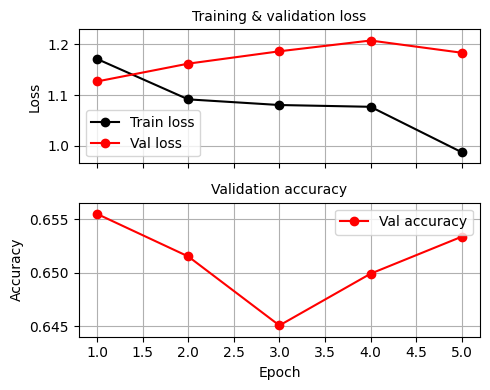

Epoch 5 summary:
  Total epoch time: 165.46s
  Train loss: 0.9874 (time: 128.95s)
  Val   loss: 1.1835, Val acc: 0.6534 (time: 36.52s)
Saved checkpoint to: /kaggle/working/checkpoints/model_last/SingleLayerModel_23-12_10:45_epoch5.pt
  LR now: 1.000000e-04

Training finished.
Best validation loss seen: 1.1269
Best checkpoint saved at:  /kaggle/working/checkpoints/model_best
Last checkpoint saved at:  /kaggle/working/checkpoints/model_last


In [ ]:
history_single_layer = train_model(
    model = single_layer_model,
    optimizer = optimizer_single_layer,
    scheduler = scheduler_single_layer,
    num_epochs=5,
    hist_path=save_hist,
    resume_ckpt=None,
    use_amp=use_amp
)

We trained the single-layer model for only five epochs because we expected it to need less training and overfit rather quickly. Exaclty this was the case. Looking at the plots above we can see that the validation loss increases after the first epoch, and the best validation accuracy is also observed after one epoch of training (~0.655).

**Transformer Training**

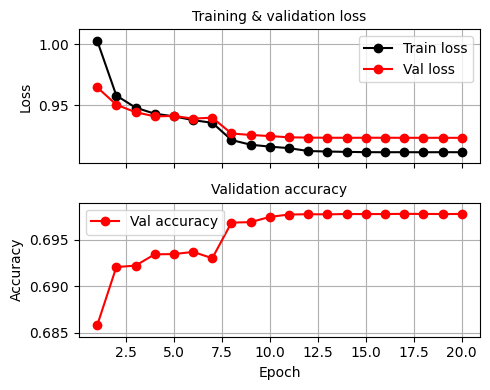

Epoch 20 summary:
  Total epoch time: 205.13s
  Train loss: 0.9119 (time: 171.63s)
  Val   loss: 0.9237, Val acc: 0.6978 (time: 33.50s)
Saved checkpoint to: /kaggle/working/checkpoints/model_last/FootballTransformer_23-12_11:56_epoch20.pt
Saved checkpoint to: /kaggle/working/checkpoints/model_best/FootballTransformer.pt
New best model based on validation loss
  LR now: 1.000000e-08
Threshold lr reached. Stopping early!

Training finished.
Best validation loss seen: 0.9237
Best checkpoint saved at:  /kaggle/working/checkpoints/model_best
Last checkpoint saved at:  /kaggle/working/checkpoints/model_last


In [ ]:
# Train from start - TRANSFORMER
history_transformer = train_model(
    model = transformer_model,
    optimizer = optimizer_transformer,
    scheduler = scheduler_transformer,
    num_epochs=num_epochs,
    hist_path=save_hist,
    resume_ckpt=None,
    use_amp=use_amp)

The transformer shows a decrease in training and validation loss until epoch eight. After that the loss curves flatten. The validation accuracy also stops increasing after 11-12 epochs, where is remains at about 0.7. The training stopped after 20 epochs because the learning rate was reduced to a value smaller than 1e-7 by the scheduler.

**LSTM Training**

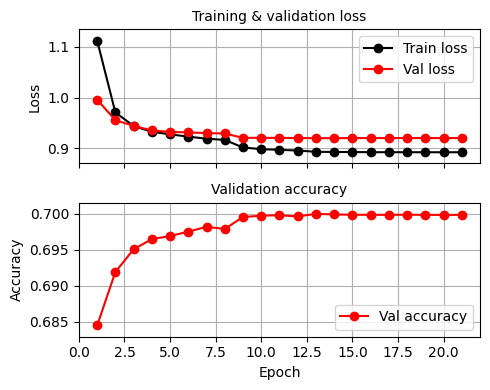

Epoch 21 summary:
  Total epoch time: 189.57s
  Train loss: 0.8920 (time: 157.49s)
  Val   loss: 0.9200, Val acc: 0.6999 (time: 32.08s)
Saved checkpoint to: /kaggle/working/checkpoints/model_last/FootballLSTM_23-12_13:3_epoch21.pt
  LR now: 1.000000e-08
Threshold lr reached. Stopping early!

Training finished.
Best validation loss seen: 0.9198
Best checkpoint saved at:  /kaggle/working/checkpoints/model_best
Last checkpoint saved at:  /kaggle/working/checkpoints/model_last


In [ ]:
# Train from start - LSTM
history_lstm = train_model(
    model = lstm_model,
    optimizer = optimizer_lstm,
    scheduler = scheduler_lstm,
    num_epochs=num_epochs,
    hist_path=save_hist,
    resume_ckpt=None,
    use_amp=use_amp)

Training and validation loss of the LSTM decrease until epoch 10 after which the loss curves seem to remain more or less constant. The validation accurary remains at around 0.7 after the tenth epoch. Also here, training was stopped early (i.e., after epoch 21) because the learning rate fell below 1e-7.

## 4. Results

Here we are going to present the results of this project. That is, our main variable of interest is model prediction performance, measured via the test set accuracies. All models will be compared on this metric. All models have been trained on the same training set, and validation set performance has been tracked during training. Similarly, the same test set is going to be used to compare model performance. The model state being used, is going to be the instance where each model achieved the highest validation accuracy. Additionally, we included confusion matrices to gain more insights into what kind of mistakes the models make and how they differ from each other.

**TEST SET ACCURACY**

In [44]:
def test_model(model, test_loader, optimizer, best_ckpt_path = best_ckpt_path, suppress_print = False):
    """Convenience function to get the test performance and immediately print it"""

    # Select the model with the highest performance
    ckpt_path = os.path.join(best_ckpt_path, model.__class__.__name__ + ".pt")
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    print("Loaded best checkpoint from:", best_ckpt_path)
    print("Best val loss stored in ckpt:", ckpt.get("best_val_loss", "N/A"))

    test_loss, test_acc, conf_mat = one_epoch(model = model, optimizer=optimizer, dataloader=test_loader, epoch_idx=0, use_amp=use_amp, train = False)

    if not suppress_print:
        print("\n=== TEST RESULTS ===")
        print(f"Test loss: {test_loss:.4f}")
        print(f"Test acc : {test_acc:.4f}")

    return test_loss, test_acc, conf_mat


**Accuracy Single layer model**

In [45]:
test_loss_sl, test_acc_sl, conf_mat_sl = test_model(
    single_layer_model,
    hist_path = save_hist,
    optimizer = optimizer_single_layer,
    best_ckpt_path = best_ckpt_path,
    test_loader = test_loader
)


Loaded best checkpoint from: /kaggle/working/checkpoints/model_best
Best val loss stored in ckpt: 1.1269236704005365
  [epoch 1, batch 1000] avg val loss: 1.1222, avg val acc: 0.6556
  [epoch 1, batch 2000] avg val loss: 1.1256, avg val acc: 0.6548

=== TEST RESULTS ===
Test loss: 1.1245
Test acc : 0.6548


**Accuracy Transformer Model**

In [46]:
test_loss_tr, test_acc_tr, conf_mat_tr = test_model(
    transformer_model,
    hist_path = save_hist,
    optimizer = optimizer_transformer,
    best_ckpt_path = best_ckpt_path,
    test_loader = test_loader
)


Loaded best checkpoint from: /kaggle/working/checkpoints/model_best
Best val loss stored in ckpt: 0.923656140451082
  [epoch 1, batch 1000] avg val loss: 0.9202, avg val acc: 0.6980
  [epoch 1, batch 2000] avg val loss: 0.9247, avg val acc: 0.6973

=== TEST RESULTS ===
Test loss: 0.9242
Test acc : 0.6968


**Accuracy LSTM Model**

In [47]:
test_loss_lstm, test_acc_lstm, conf_mat_lstm = test_model(
    lstm_model,
    hist_path = save_hist,
    optimizer = optimizer_lstm,
    best_ckpt_path = best_ckpt_path,
    test_loader = test_loader
)


Loaded best checkpoint from: /kaggle/working/checkpoints/model_best
Best val loss stored in ckpt: 0.9197644419776323
  [epoch 1, batch 1000] avg val loss: 0.9169, avg val acc: 0.6999
  [epoch 1, batch 2000] avg val loss: 0.9205, avg val acc: 0.6989

=== TEST RESULTS ===
Test loss: 0.9195
Test acc : 0.6988


The results above show that all models already perform reasonably well, with the LSTM being the best performing model with 0.6988 accuracy on the test set, compared to 0.6968 accuracy of the transformer model. Even the single layer model performed at 0.65 accuracy. However, a baseline comparison is missing, which is why in the next cell, we are computing accuracy for the case of only predicting majority class, which can then be compared to model accuracy, to see if the model's complexity add anything to the prediction accuracy.

**MAJORITY CLASS AND UNIFORM PROBABILITIES**

In [48]:
majority_df = X_test.copy()
# group by match id to exclude the first 29 next event labels since they are never predicted
# the 30th next event label (WINDOW_SIZE) is included in the predictions since the labels are shifted -1 position
excl_start = X_test.groupby("match_id").cumcount() >= WINDOW_SIZE - 1 # set first WINDOW_SIZE - 1 rows to False
# the <BOM> token never gets predicted becuase of the WINDOW predictions cannot overlap matches
excl_bom = X_test.groupby("match_id").cumcount(ascending=False) > 0 # set last row to False

valid_pred = excl_start & excl_bom

majority_df = majority_df.loc[valid_pred, "label"].to_numpy()
cat_names = []
for idx in range(len(majority_df)):
  cat_names.append(codes_map["input_event"][majority_df[idx]])
cat_names = pd.Series(cat_names)
label_counts = cat_names.value_counts()
label_probs  = cat_names.value_counts(normalize=True)
num_classes = label_counts.shape[0]

print("Num classes in test:", num_classes)
print("\nTop 5 label probs (test):")
print(label_probs[:5])

print("\nMajority-class probability:", label_probs.iloc[0])
print("Guessing probability:", 1/num_classes)

Num classes in test: 14

Top 5 label probs (test):
PASS            0.547067
DUEL            0.262753
INTERCEPTION    0.052066
BALL_OUT        0.041542
RECOVERY        0.035849
Name: proportion, dtype: float64

Majority-class probability: 0.5470674323134356
Guessing probability: 0.07142857142857142


**Majority class and chance level accuracy**
Majority-class probability: 0.547  
Chance level: 0.071

**ACCURACY PLOTS**

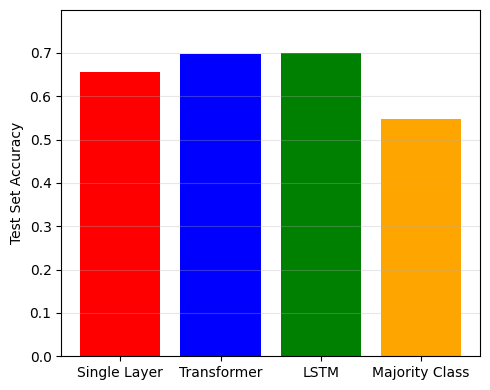

In [72]:
labels = ["Single Layer", "Transformer", "LSTM", "Majority Class"]
values = [test_acc_sl, test_acc_tr, test_acc_lstm, label_probs.iloc[0]]
x = np.arange(len(labels))

plt.figure(figsize=(5, 4))
plt.bar(x, values, color=["red", "blue", "green", "orange"])
plt.xticks(x, labels)
plt.ylabel("Test Set Accuracy")
plt.ylim(0, max(values) + 1e-1)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

Clearly, all models perform above the accuracy that would be achieved if only majority class (i.e. pass; accuracy = 0.54) would be predicted. As already mentioned above, LSTM and Transformer perform similarly. Both have a higher accuracy than the Single Layer model. Unfortunately, Simpson et al. (2022) did not report their overall model accuracies, which makes it hard to compare our models to their approach.

### 4.1 Confusion Matrices

As can be seen above all models perform reasonably well with the LSTM and Transformer performing close to 0.70 accuracy. However, we wanted to get a better understanding of what kinds of mistakes the models make and therefore better understand what can be imporved to achieve even higher accuracy levels. Below, you can see the confusion matrices for all models, with true next events on the y-axis and actual predicted event by the model on the x-axis. We normalised the rows, so they represent probability distributions conditioned on the true event indicated in each row.

In [73]:
def plot_conf_mat(conf_mat, title=None):
    """
    Function takes a history dictionary from training as input.
    Plots the confusion matrix as a heatmap.
    """
    # Compute confusion matrix, move it to CPU and convert to numpy array
    val_conf_mat = conf_mat.compute().cpu().numpy()

    # Get event names in correct order
    event_names = codes_map["input_event"].values()

    # Turn confusion matrix into pandas dataframe
    val_cm_df = pd.DataFrame(val_conf_mat, index=event_names, columns=event_names)

    # Divide each colum entry by the row sum to get P(pred|target)
    cm_prob = val_cm_df.div(val_cm_df.sum(axis=1), axis=0) # rows are nomalised now

    # The GENERIC:generic class contains events that do not fall into the other classes.
    # Let's give it a more intuitive name.
    # The conversion to probabilities within rows led to NAs because <BOM> is never predicted
    # since the context window can never span two matches. We remove the NAs.
    cm_prob = cm_prob.rename(
        columns={"GENERIC:generic": "OTHER"},
        index={"GENERIC:generic": "OTHER"}).dropna(axis=0)

    # Plot the confusion matrix as a heatmap
    cmap = sns.color_palette("flare", as_cmap=True)
    plt.figure()
    ax = sns.heatmap(cm_prob, cmap=cmap, linewidths=0.5, linecolor="white")
    plt.title(title)
    plt.show()
    plt.close()

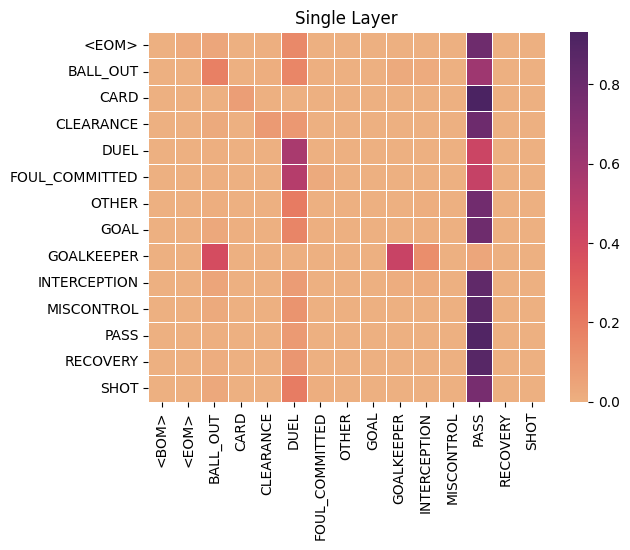

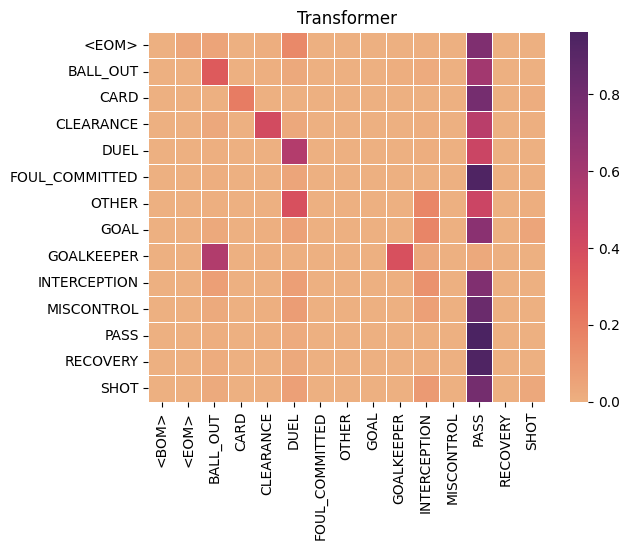

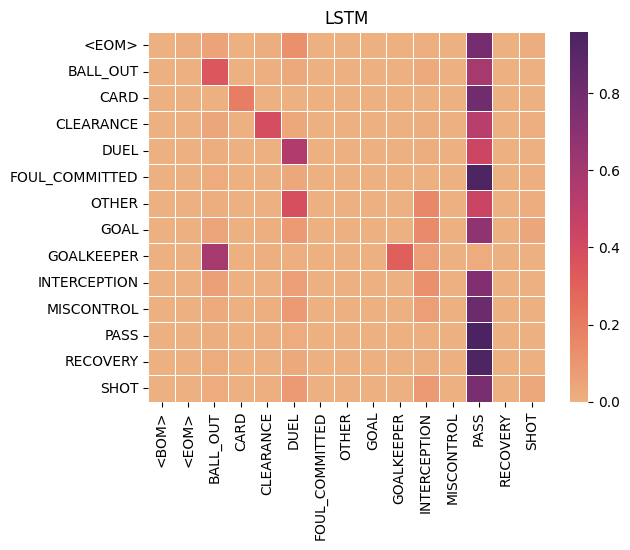

In [75]:
# Single-layer
plot_conf_mat(conf_mat_sl, title="Single Layer")

# Transformer
plot_conf_mat(conf_mat_tr, title="Transformer")

# LSTM
plot_conf_mat(conf_mat_lstm, title="LSTM")

From the confusion matrices we can see exactly what the models have learned. From the first glance, we can see that all three models perform remarkably similar. All predict pass for almost all true events. This is probably because pass is by far the most likely event in the data. Next, instead of Goalkeeper, the model more likely predicts ball out, which likely indicates that shots will more likely be off target compared to on target. Because of the model's naive predicting behaviour (predicting passes at basically all times), we thought of countering this effect with a weighted loss function as can be seen in the next cell.

### 4.2 Weighted Loss Idea (Transformer Implementation)

As seen in the confusion matrices above, the model almost always predicts pass as the next event, most likely because it is the most probable event. To make the model learn about the other event classes as well, we thought of modifying the loss function. Here, we implemented a weighted loss function, downweighting the events, relative to how often they occur in the dataset (cf. Simpson et al., 2022). In practical terms, this means that when the model correctly predicts a rare event (e.g. interception or miscontrol), the weights get adjusted more strongly, compared to when it correctly predicts a common event (e.g. pass). The idea is that with this, the model cares more about rare events compared to common events.

In [ ]:
counts = X_train["input_event"].value_counts() # counts of event classes
prop = X_train["input_event"].value_counts(normalize=True) # proportions of event classes
inv_perc = 1/prop # weights are the inverse proportions
print("EVENT WEIGHTS")
print(inv_perc)

weights = inv_perc.copy()
weights_dict = weights.sort_index().to_dict()

weights_tensor = torch.tensor(list(weights_dict.values())).to(device)
print("\n", weights_tensor)

We specify new folders to save the training checkpoints and histories to avoid overwriting the previous ones.

In [55]:
# To save intermediate weights & history
root_path = os.getcwd() # Specify where you want this to be saved

save_ckpt = os.path.join(root_path, "checkpoints/weighted loss")
os.makedirs(save_ckpt, exist_ok=True) # create the folder if doesn't exist

save_hist = os.path.join(root_path, "histories/weighted loss/")
os.makedirs(save_hist, exist_ok=True)

last_ckpt_path = os.path.join(save_ckpt, "model_last/weighted loss")
os.makedirs(last_ckpt_path, exist_ok=True)
best_ckpt_path = os.path.join(save_ckpt, "model_best/weighted loss")
os.makedirs(best_ckpt_path, exist_ok=True)

Finally, we pass the weights into the `CrossEntropyLoss` function and train the transformer.

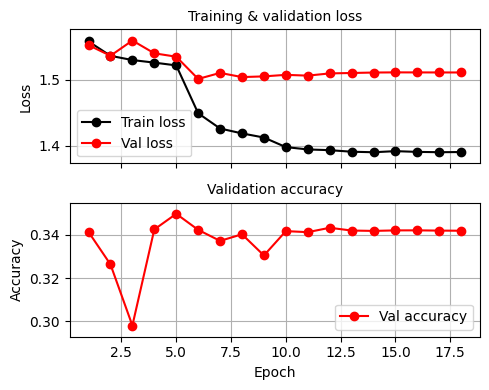

Epoch 18 summary:
  Total epoch time: 197.02s
  Train loss: 1.3905 (time: 165.60s)
  Val   loss: 1.5114, Val acc: 0.3420 (time: 31.42s)
Saved checkpoint to: /kaggle/working/checkpoints/weighted loss/model_last/weighted loss/FootballTransformer_23-12_14:13_epoch18.pt
  LR now: 1.000000e-08
Threshold lr reached. Stopping early!

Training finished.
Best validation loss seen: 1.5016
Best checkpoint saved at:  /kaggle/working/checkpoints/weighted loss/model_best/weighted loss
Last checkpoint saved at:  /kaggle/working/checkpoints/weighted loss/model_last/weighted loss


In [ ]:
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor) # weighted loss
# Transformer
optimizer_transformer = torch.optim.AdamW(transformer_model.parameters(), lr=LEARNING_RATE)
scheduler_transformer = ReduceLROnPlateau(optimizer_transformer, threshold=1e-2, factor=0.1, patience=PATIENCE)

# Train from start - TRANSFORMER
history_transformer_weighted = train_model(
    model = transformer_model,
    optimizer = optimizer_transformer,
    scheduler = scheduler_transformer,
    num_epochs=num_epochs,
    hist_path=save_hist,
    resume_ckpt=None,
    use_amp=use_amp)

The validation loss decreases until epoch six. Afterwards, it stays more or less constant. While the training loss continues to decrease after epoch six, the validation accuracy reaches its maximum at epoch 5 (~0.345).

Loaded best checkpoint from: /kaggle/working/checkpoints/weighted loss/model_best/weighted loss
Best val loss stored in ckpt: 1.5016218609313963
  [epoch 1, batch 1000] avg val loss: 1.7249, avg val acc: 0.3509
  [epoch 1, batch 2000] avg val loss: 1.7263, avg val acc: 0.3439

=== TEST RESULTS ===
Test loss: 1.7296
Test acc : 0.3428


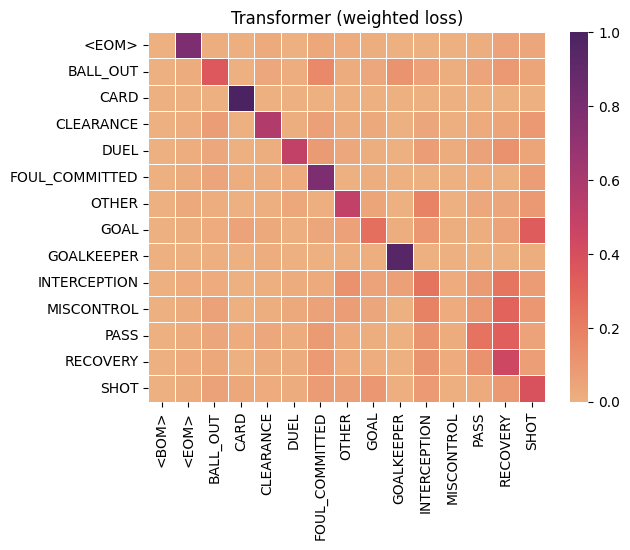

In [76]:
test_loss_w, test_acc_w, conf_mat_w = test_model(
    transformer_model,
    hist_path = save_hist,
    optimizer = optimizer_transformer,
    best_ckpt_path = best_ckpt_path,
    test_loader = test_loader
)
plot_conf_mat(conf_mat_w, title="Transformer (weighted loss)")

As can be seen in the confusion matrix above, when more common events are penalized, the model is able to predict rare events better compared to the model without the weighted loss function. This is indicated by the highest probabilities being the predicted event that matches the true event in the row for most of the classes. However, the accuracy is noticibly lower (0.3428), compared to the model without the weighted loss function. This is because, although passes still are the majority event in the data, the model now refuses to predict it. Still, it shows that generally the model is able to predict these rare events, it just leads to higher accuracy to predict the majority event most of the time.

## 5. Discussion
In this project, we showed that transformer and recurrent LSTM models can predict next events in football match data equally well and outperform both majority class prediction and a single-layer model. However, it seems that both models rely heavily on predicting the majority event (i.e., they predict mostly PASS). Nevertheless, we also show that the transformer can learn deeper structures when trained with a weighted loss function. Given the relatively good performance of these models, we expect them to generalize equally well on other types of sport data.

Several limitations remain. First, the dataset (~ 2 million points) might be too small to train such data-hungry models. Second, the number of unique events the model has to predict might be too much. As such, in addition to more data, further collapsing events could improve performance. Third, including player-level information (e.g., individual player positions or player distributions on the field) might help the models to extract more information and improve performance.

One interesting idea to explore is to train the model in stages; first train it on an event-rich dataset and then fine-tune it on a compressed event dataset with a weighted loss function. Another idea is to make the models generative; by feeding a segment of the match, the models could iteratively make next-event predictions until they predict the end of the match. It would be interesting to explore what type and how much information is necessary for this type of models.

Overall, these results suggest that DNNs are well suited to predict structured sport-related time-series data. With increasing interest in machine learning techniques in the football industry (and other sports), such models can provide great value to managers and technical staff by assisting match analyses.

## 6. Division of labour
We mostly met up and worked on the project at the same time, so everyone contributed equally to all parts of the project.

## 7. References
Hall, T., & Rasheed, K. (2025). A Survey of Machine Learning Methods for Time Series Prediction. *Applied Sciences*, *15*(11), 5957. https://doi.org/10.3390/app15115957

OpenAI. (2025). ChatGPT (Dec 22 version) [Large language model]. https://chat.openai.com/chat

Pappalardo, L., Cintia, P., Rossi, A., Massucco, E., Ferragina, P., Pedreschi, D., & Giannotti, F. (2019). A public data set of spatio-temporal match events in soccer competitions. *Scientific Data, 6*(1), 236. https://doi.org/10.1038/s41597-019-0247-7

Simpson, I., Beal, R. J., Locke, D., & Norman, T. J. (2022). Seq2Event: Learning the language of soccer using transformer-based match event prediction. *Proceedings of the 28th ACM SIGKDD Conference on Knowledge Discovery and Data Mining*, 3898–3908. https://doi.org/10.1145/3534678.3539138

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is all you need. *Advances in Neural Information Processing Systems, 30*.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a7159be7-402c-457e-b158-4e16e892eaf8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>